## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


```
Название поля       Описание
user_id	            идентификатор пользователя, зашедшего на сайт
date	            дата захода
group	            группа теста (контрольная — А или тестовая — B)
purchase	    признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)
price	            цена купленного тура (если покупка не состоялась, цена равна 0)
```

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

grouped_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'}).reset_index().rename(columns={'user_id':'users_count'})
mask_a = grouped_data['group'] == 'A'
mask_b = grouped_data['group'] == 'B'

print('Group A:', 
      grouped_data[mask_a]['date'].nsmallest(1).dt.date.values[0],
      '-',
      grouped_data[mask_a]['date'].nlargest(1).dt.date.values[0])
print('Group B:', 
      grouped_data[mask_b]['date'].nsmallest(1).dt.date.values[0],
      '-',
      grouped_data[mask_b]['date'].nlargest(1).dt.date.values[0])

Group A: 2021-01-02 - 2021-01-24
Group B: 2021-01-02 - 2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
quantity_a = grouped_data[mask_a]['users_count'].sum()
quantity_b = grouped_data[mask_b]['users_count'].sum()

sum_purchese_a = grouped_data[mask_a]['purchase'].sum()
sum_purchese_b = grouped_data[mask_b]['purchase'].sum()

amount_price_a = grouped_data[mask_a]['price'].sum()
amount_price_b = grouped_data[mask_b]['price'].sum()

print(f'Суммарное количество посещений в группе А - {quantity_a}, в группе B - {quantity_b}')
print(f'Суммарное количество покупок в группе А - {sum_purchese_a}, в группе B - {sum_purchese_b}')
print(f'Общая сумма всех покупок в группе А - {amount_price_a/1000000} млн.руб., в группе B - {amount_price_b/1000000} млн.руб.')

Суммарное количество посещений в группе А - 147202, в группе B - 147276
Суммарное количество покупок в группе А - 17723, в группе B - 17514
Общая сумма всех покупок в группе А - 1436.26 млн.руб., в группе B - 1554.1 млн.руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [7]:
users_a = set(data[data['group'] == 'A']['user_id']) 
users_b = set(data[data['group'] == 'B']['user_id'])

users_ab = users_a.intersection(users_b) # множество id пользователей, которые есть в обеих группах

print(f'{len(users_ab)} пользователей попали в обе группы')

1895 пользователей попали в обе группы


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in users_ab)]

update_users_a = set(updated_data[updated_data['group'] == 'A']['user_id']) 
update_users_b = set(updated_data[updated_data['group'] == 'B']['user_id'])

update_users_ab = update_users_a.intersection(update_users_b) # множество id пользователей, которые есть в обеих группах

print(f'{len(update_users_ab)} пользователей попали в обе группы')

0 пользователей попали в обе группы


Где users_ab - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

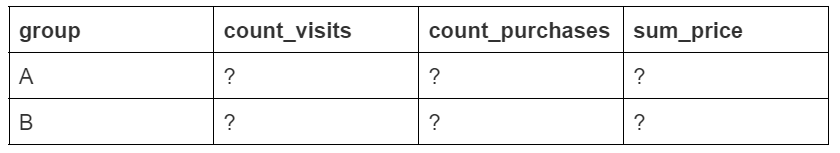
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [9]:
ab_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
    }).rename(columns={
        'user_id':'count_visits', 
        'purchase':'count_purchase', 
        'price':'sum_price'})
display(ab_data)

,count_visits,count_purchase,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### ***Промежуточный вывод***

Как видно из таблицы количество посещений в двух группах имеют один порядок и отличаются незначительно, поэтому выборки можно считать сбалансированными.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
ab_data['conversion'] = ab_data['count_purchase']/ab_data['count_visits']*100
ab_data['mean_check'] = ab_data['sum_price']/ab_data['count_purchase']

#display(ab_data)

print(
    'Конверсия в группе A:', 
    round(ab_data['conversion'][0], 2),
    '\nКонверсия в группе B:',
    round(ab_data['conversion'][1], 2)
    )
print(
    'Средний чек в группе А:', 
    round(ab_data['mean_check'][0]),
    '\nСредний чек в группе B:',
    round(ab_data['mean_check'][1])
    )

Конверсия в группе A: 12.03 
Конверсия в группе B: 11.89
Средний чек в группе А: 81076 
Средний чек в группе B: 88665


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### ***Промежуточный вывод***

Исходя из полученных данных конверсия в группе А больше, чем в группе В. А средний чек для группы В превосходит средний чек для группы А. Поэтому пока сложно судить об эффективности какой-то из групп.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
purchasing_power = pd.crosstab(
    updated_data['price'],
    updated_data['group'],
    values=updated_data['purchase'],
    aggfunc='sum'
)

#display(purchasing_power)

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

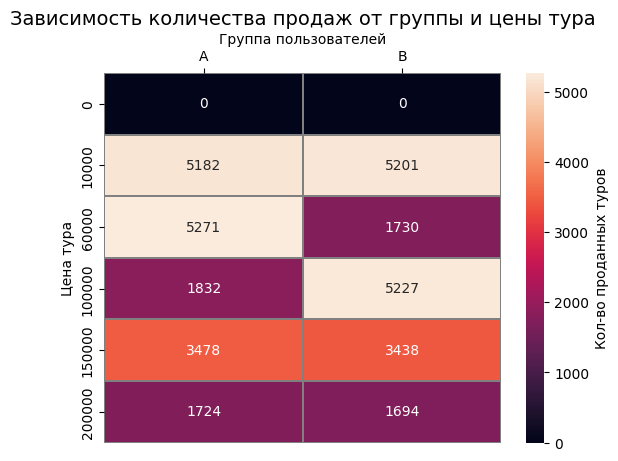

In [34]:
ax = sns.heatmap(purchasing_power, annot=True, fmt='.0f', cbar_kws={'label':'Кол-во проданных туров'}, linewidths=0.1,linecolor='grey')
ax.set_title('Зависимость количества продаж от группы и цены тура', fontsize=14)
ax.set_xlabel('Группа пользователей', loc='center')
ax.set_ylabel('Цена тура')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### ***Промежуточный вывод***

Для туров стоимостью 10 000, 150 000 и 200 000 рублей количество проданных туров в группах отличается незначительно. Для туров стоимостью 60 000 в группе А продано больше туров, чем в группе В, а вот для туров стоимостью 100 000 наоборот в группе В продано больше. Исходя из полученного можно заключить, что в группе В было продано большее количество дорогих туров по сравнению с группой А, что мы ранее получили и при сравнении средних чеков. Также можно заметить, что в наших данных нет проданных туров дешевле 10 000 рублей.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [13]:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchase',
    'price':'sum_price'
    })

#display(daily_data.head())

daily_data['daily_conversion'] = daily_data['count_purchase']/daily_data['count_visits']*100
daily_data['daily_mean_check'] = daily_data['sum_price']/daily_data['count_purchase']

mask_date_a = (daily_data['date'] == '2021-01-03')&(daily_data['group'] == 'A')
mask_date_b = (daily_data['date'] == '2021-01-03')&(daily_data['group'] == 'B')

print('Конверсия в группе А 3 января 2021 года:', round(daily_data[mask_date_a]['daily_conversion'].values[0],2))
print('Конверсия в группе В 3 января 2021 года:', round(daily_data[mask_date_b]['daily_conversion'].values[0],2))
print('Средний чек в группе А 3 января 2021 года:', round(daily_data[mask_date_a]['daily_mean_check'].values[0]))
print('Средний чек в группе В 3 января 2021 года:', round(daily_data[mask_date_b]['daily_mean_check'].values[0]))

Конверсия в группе А 3 января 2021 года: 11.34
Конверсия в группе В 3 января 2021 года: 11.39
Средний чек в группе А 3 января 2021 года: 82888
Средний чек в группе В 3 января 2021 года: 87480


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [14]:
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
daily_data['cum_purchase'] = daily_data.groupby(['group'])['count_purchase'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_purchase']/daily_data['cum_count_visits'] * 100
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_purchase']
display(daily_data.head())

mask_cum_b= (daily_data['date'] == '2021-01-20')&(daily_data['group'] == 'B')
mask_cum_a = (daily_data['date'] == '2021-01-12')&(daily_data['group'] == 'A')

print('Кумулятивная конверсия в группе В 20 января 2021 года:', 
      round(daily_data[mask_cum_b]['cum_conversion'].values[0],2)
      )
print('Кумулятивный средний чек в группе А 12 января 2021 года:', 
      round(daily_data[mask_cum_a]['cum_mean_check'].values[0])
      )

,date,group,count_visits,count_purchase,sum_price,daily_conversion,daily_mean_check,cum_count_visits,cum_purchase,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


Кумулятивная конверсия в группе В 20 января 2021 года: 11.9
Кумулятивный средний чек в группе А 12 января 2021 года: 81492


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

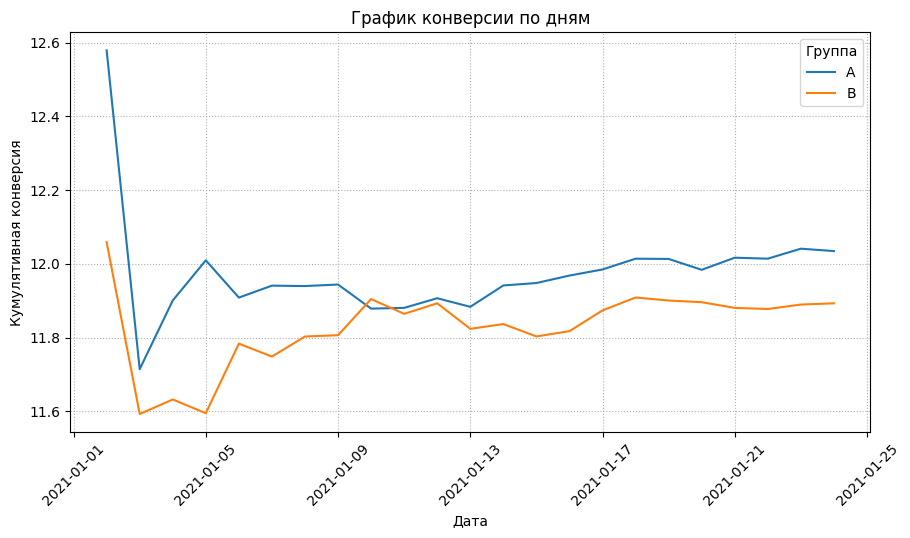

In [15]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])

sns.lineplot(
    data=daily_data,
    x='date',
    y='cum_conversion',
    hue='group', 
    ax=ax
)

ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Дата')
ax.set_ylabel('Кумулятивная конверсия')
ax.legend(title='Группа')
ax.grid(linestyle=':');

### ***Промежуточный вывод***

Начиная с 17 января 2021 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе А стабильно выше конверсии в группе В на данном периоде. При этом практически на всем промежутке времени конверсия в группе А показывает лучший результат, чем в группе В.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 

_, p_value = proportions_ztest(
    count=ab_data['count_purchase'],
    nobs=ab_data['count_visits'],
    alternative='larger',
)

print('p-value: ', round(p_value, 2))

if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### ***Промежуточный вывод***

Используя z-тест для проверки гипотезы равенства пропорций, получили, что значение $p-value > \alpha=0.05$, а это значит, что мы принимаем нулевую гипотезу о равенстве конверсии в группах А и В. Значит с точки зрения статистической значимости, данные группы не имеют значимых отличий в метрике конверсии и варианты посадочных страниц одинаково эффективны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

Доверительный интервал А: 11.87 - 12.2
Доверительный интервал B: 11.73 - 12.06
Доверительный интервал для разности конверсий: -0.38 - 0.09


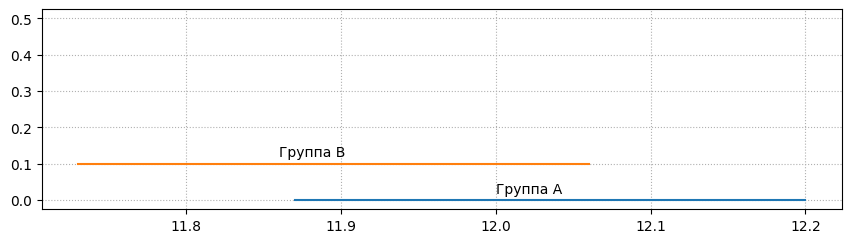

In [17]:
gamma = 0.95
alpha = 1 - gamma
z_crit = -norm.ppf(alpha/2)

a_data = updated_data[updated_data['group'] == 'A']
n_a=a_data['purchase'].count()
x_p_a=a_data['purchase'].mean()

eps_a = z_crit * (x_p_a * (1 - x_p_a) / n_a) ** 0.5
lower_bound_a = x_p_a - eps_a
upper_bound_a = x_p_a + eps_a
print('Доверительный интервал А:', round(lower_bound_a * 100, 2), '-', round(upper_bound_a * 100, 2))

b_data = updated_data[updated_data['group'] == 'B']
n_b=b_data['purchase'].count()
x_p_b=b_data['purchase'].mean()

eps_b = z_crit * (x_p_b * (1 - x_p_b) / n_b) ** 0.5
lower_bound_b = x_p_b - eps_b
upper_bound_b = x_p_b + eps_b
print('Доверительный интервал B:', round(lower_bound_b * 100, 2), '-', round(upper_bound_b * 100, 2))

n_ab = [a_data['purchase'].count(), b_data['purchase'].count()]
x_p_ab= [a_data['purchase'].mean(), b_data['purchase'].mean()]

diff = x_p_ab[1] - x_p_ab[0]
eps_delta = z_crit * (x_p_ab[0] * (1 - x_p_ab[0])/n_ab[0] + x_p_ab[1] * (1 - x_p_ab[1])/n_ab[1]) ** 0.5
lower_bound_delta = diff - eps_delta
upper_bound_delta = diff + eps_delta
print('Доверительный интервал для разности конверсий:', round(lower_bound_delta * 100, 2), '-', round(upper_bound_delta * 100, 2))

x_a = [round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2)]
y_a = [0, 0]
x_b = [round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2)]
y_b = [0.1, 0.1]

fig = plt.figure(figsize=(8, 2))
ax = fig.add_axes([1, 1, 1, 1])
plt.plot(x_a, y_a, x_b, y_b, 12, 0.5)
ax.annotate('Группа А', xy=(x_a[1]-0.2, 0.02))
ax.annotate('Группа B', xy=(x_b[1]-0.2, 0.12))
ax.grid(linestyle=':');


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### ***Промежуточный вывод***

С надежностью в 95% конверсия группы А $\in (11.87, 12.2)$, а конверсия группы B $\in (11.73, 12.06)$. На схематичном изображении доверительных интервалов видно пересечение, а это значит, что значение конверсии для генеральной совокупности в обеих группах может совпасть. При этом доверительный интервал разности конверсий охватывает $0$, из чего можно сделать вывод, что варианты посадочных страниц по метрике конверсии равнозначны и статистической разницы между группами А и В не существует.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [18]:
alpha = 0.05

H0_a = 'Данные ежедневного среднего чека в группе A распределены нормально'
H1_a = 'Данные ежедневного среднего чека в группе А имеют распределение отличное от нормального'

p_a = round(shapiro(daily_data[daily_data['group'] == 'A']['daily_mean_check'])[1], 3)
print(f'p-value = {p_a}')

if p_a > alpha:
    print(f'{p_a} > {alpha}: {H0_a}')
else:
    print(f'{p_a} <= {alpha}: {H1_a}')
    
H0_b = 'Данные ежедневного среднего чека в группе B распределены нормально'
H1_b = 'Данные ежедневного среднего чека в группе B имеют распределение отличное от нормального'

p_b = round(shapiro(daily_data[daily_data['group'] == 'B']['daily_mean_check'])[1], 3)
print(f'p-value = {p_b}')

if p_b > alpha:
    print(f'{p_b} > {alpha}: {H0_b}')
else:
    print(f'{p_b} <= {alpha}: {H1_b}')

p-value = 0.253
0.253 > 0.05: Данные ежедневного среднего чека в группе A распределены нормально
p-value = 0.094
0.094 > 0.05: Данные ежедневного среднего чека в группе B распределены нормально


### ***Промежуточный вывод***

Так как в наших данных рассматривается средний чек за период 25 дней, то для проверки нормальности используем тест Шапиро_Уилка, он показывает надежный результат на небольших выборках. В качестве нулевых гипотез мы предположили, что данные ежедневного среднего чека в группах А и В распределены нормально, альтернативной гипотезой стало обратное утверждение о негауссовском распределении данных по ежедневным средним чекам в группах. Каждую группу проверили отдельно. В итоге получили, что наблюдения ежедневного среднего чека в группе А и в группе В распределены нормально. А значит в дальнейших исследованиях будем применять параметрические статистические методы исследования.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [19]:
H0 = 'Ежедневные средние чеки в группах А и В равны (нет значимой корреляции между выборками)'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе В (есть статистически значимая корреляция)'

alpha = 0.05

mask_a = daily_data['group'] == 'A'
mask_b = daily_data['group'] == 'B'

p = round(ttest_ind(daily_data[mask_a]['daily_mean_check'], daily_data[mask_b]['daily_mean_check'], equal_var=True, alternative='less')[1], 3)
print(f'p-value = {p}')

if p > alpha:
    print(f'{p} > {alpha}: {H0}')
else:
    print(f'{p} <= {alpha}: {H1}')

p-value = 0.0
0.0 <= 0.05: Ежедневный средний чек в группе А меньше чем в группе В (есть статистически значимая корреляция)


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### ***Промежуточный вывод***

Так как ранее мы определили, что данные о ежедневном среднем чеке распределены нормально, сравнивать мы будем две группы (А и В) и количество наблюдений у нас менее 30 (данные взяты за 25 дней), то для сравнения наших групп будем использовать T-тест. В итоге получили, что ежедневный средний чек в группе А меньше чем в группе В, а это значит, что по метрике ежедневного среднего чека вариант дизайна посадочной страницы в группе В приносит большую прибыль, так как с ее помощью продается большее количество дорогих туров, эти же данные мы получили, когда строили тепловую карту зависимости количества продаж от группы и цены тура. Предварительно можно сказать, что для большей прибыли вариант посадочной страницы В предпочтительнее.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ округлите до целого.

Доверительный интервал среднего чека группы А: 79630 - 82308
Доверительный интервал среднего чека группы B: 87626 - 89526


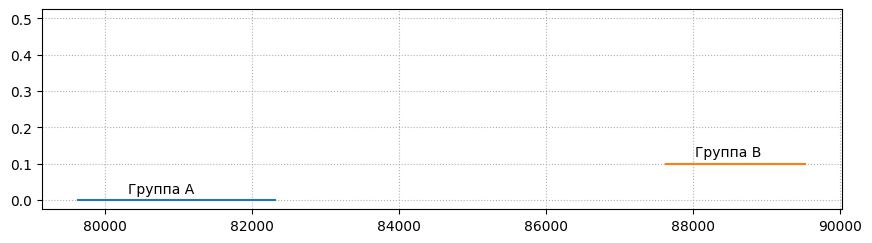

In [20]:
gamma = 0.95
alpha = 1 - gamma

a_data = daily_data[daily_data['group'] == 'A']
n_a = a_data['daily_mean_check'].count()
k_a = n_a - 1
x_mean_a = a_data['daily_mean_check'].mean()
x_std_a = a_data['daily_mean_check'].std()
t_crit_a = -t.ppf(alpha/2, k_a)

eps_a = t_crit_a *x_std_a/(n_a**0.5)
lower_bound_a = x_mean_a - eps_a
upper_bound_a = x_mean_a + eps_a
print('Доверительный интервал среднего чека группы А:', round(lower_bound_a), '-', round(upper_bound_a))

b_data = daily_data[daily_data['group'] == 'B']
n_b = b_data['daily_mean_check'].count()
k_b = n_b - 1
x_mean_b = b_data['daily_mean_check'].mean()
x_std_b = b_data['daily_mean_check'].std()
t_crit_b = -t.ppf(alpha/2, k_b)

eps_b = t_crit_b *x_std_b/(n_b**0.5)
lower_bound_b = x_mean_b - eps_b
upper_bound_b = x_mean_b + eps_b
print('Доверительный интервал среднего чека группы B:', round(lower_bound_b), '-', round(upper_bound_b))

x_a = [round(lower_bound_a), round(upper_bound_a)]
y_a = [0, 0]
x_b = [round(lower_bound_b), round(upper_bound_b)]
y_b = [0.1, 0.1]

fig = plt.figure(figsize=(8, 2))
ax = fig.add_axes([1, 1, 1, 1])
plt.plot(x_a, y_a, x_b, y_b, 80000, 0.5)
ax.annotate('Группа А', xy=(x_a[1]-2000, 0.02))
ax.annotate('Группа B', xy=(x_b[1]-1500, 0.12))
ax.grid(linestyle=':');

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### ***Промежуточный вывод***

Так как между доверительными интервалами нет пересечений, можно сказать, что с вероятностью 95% средние значения в генеральных совокупностях для группы А и В будут различны, а различия между выборочными средними можно считать статистически значимыми.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Исходя из полученных результатов А/В-теста можно сделать вывод, что в комплексе по метрикам конвесии и среднего чека лучшей является вариант посадочной страницы В, так как несмотря на то, что он равнозначен варианту посадочной страницы А по конверсии, он значимо лучше варианта А, по среднему чеку, а значит принесет бОльшую прибыль туристическому агенству.